In [47]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from itertools import product
from numpy.linalg import cholesky, inv
import plotly.graph_objs as go
import plotly.offline as po

import funciones_optim
from importlib import reload
reload(funciones_optim)
from funciones_optim import backt
from funciones_optim import graphs
from funciones_optim import BLopt, mvo
from datetime import timedelta

import warnings
warnings.filterwarnings("ignore")

In [3]:
prs = pd.read_csv('probs.csv',index_col=0)
prtest = prs.loc['2020-10':,:]
r_ = pd.read_csv('m_returns.csv',index_col=0)
r_ =  r_.add(1).apply(np.log)
qaoa = pd.read_csv('ws_qaoa.csv',index_col=0)

In [18]:
x0 = [0.25,0.25,0.25,0.25,0.25]
bnds = ((0, 1), (0, 1),(0, 1),(0, 1),(-0.5, 1.5))
vx = 10
coef_conv = 2

In [39]:
ws_=[]
wseq=[]
wsv= []
wsqaoa=[]
for i in prtest.index:
    rr = r_.loc[:i,:].iloc[-252*5:,:]
    m_ = rr.median().mul(12).mul(100)
    m_.loc['SPX'] = m_.loc['SPX'] +1.5 #DIV YIELD
    m_.loc['EEM'] = m_.loc['EEM'] +3 # DIV YIELD
    corr_ = rr.corr()
    vol_ = rr.std().mul(np.sqrt(12)).mul(100)
    corr_ = pd.DataFrame(corr_.values,columns=vol_.values,index=vol_.values)
    sigma_ = corr_.copy()

    for ix,jx in product(vol_,repeat=2):
        sigma_.loc[ix,jx] = corr_.loc[ix,jx]*ix*jx

    req,weq =mvo(m_,sigma_,vx,x0,bnds)
    wseq.append(weq)
    c = 1/(np.sqrt([(pr -0.5)**2 for pr in prtest.loc[i,:]])*coef_conv)
    q = [2*(pr -0.5) for pr in prtest.loc[i,:]]
    mu_bl,sigma_bl,v,omega = BLopt(m_,sigma_.values,q,c)
    rbl,wbl = mvo(mu_bl,sigma_bl,vx,x0,bnds)

    # filtro qaoa
    vi = qaoa.loc[i,:]
    wi = 1/np.sum(vi.iloc[:-1])
    x0i= np.multiply(np.ones(len(vi))*wi,vi.values)
    bnds_i = tuple([(0, vi.loc[_]) if _!='USDCOP' else (vi.loc[_]*-0.5,vi.loc[_]*1.5) for _ in vi.index ])
    rq,wq = mvo(mu_bl,sigma_bl,vx,x0i,bnds_i)
    wsqaoa.append(wq)

    ws_.append(wbl)
    rv,wv = mvo(v,sigma_,vx,x0,bnds)
    wsv.append(wv)

ws_ = pd.concat(ws_,axis=1).transpose()
ws_.index= pd.to_datetime(prtest.index)

wseq = pd.concat(wseq,axis=1).transpose()
wseq.index= pd.to_datetime(prtest.index)

wsv = pd.concat(wsv,axis=1).transpose()
wsv.index= pd.to_datetime(prtest.index)

wsqaoa = pd.concat(wsqaoa,axis=1).transpose()
wsqaoa.index= pd.to_datetime(prtest.index)

In [23]:
#backtest
p = backt.loadprices()

In [24]:
rt = p.apply(backt.rt,args=[p],axis=0).drop(['USCASH'],axis=1)
rt = rt.loc[:,['SPX','EEM','XAU','USTTEN','COCASH','USDCOP']]
r = rt.drop(['COCASH'],axis=1)

<Axes: >

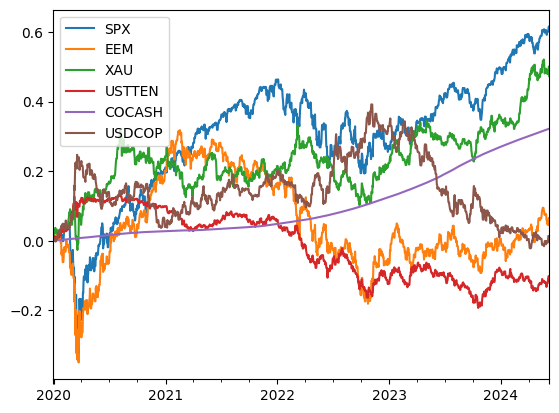

In [46]:
rt.cumsum().plot()

In [25]:
sdate = ws_.index[0]
fdate = ws_.index[-1]

In [40]:
ports=[]
for w in [ws_,wseq,wsv,wsqaoa]:
    wp,rp = backt.portr(r,sdate,fdate,w.iloc[0,:],rebal=True,rbw=w)
    ports.append(rp)
ports = pd.concat(ports,axis=1)
ports.columns = [f'port {c}' for c in ['model_bl','naive','model','bl_qaoa_f']]

In [41]:
df = backt.pmetrics(ports,rt.COCASH,bench=0)
df.round(3)

,port model_bl,port naive,port model,port bl_qaoa_f
ret,10.438,4.022,14.157,19.389
retm,0.315,0.153,0.414,0.521
volm,10.662,10.718,11.782,10.157
sharpe,-0.027,-0.042,-0.016,-0.008
mdd,-16.175,-19.232,-18.894,-15.100
etg/etl,1.131,1.136,1.226,1.296
downdev,2.739,2.842,2.865,2.297
sortino,0.115,0.054,0.145,0.227


In [54]:
graphs.sct(ports.add(1).apply(np.log).cumsum().apply(np.exp).mul(100).round(3),'Indices')
graphs.area(wsqaoa,f'Ws portafolio Modelo')
graphs.area_2(wsqaoa.sub(ws_),'Ws qaoa_f - bl',nofill=['USDCOP'])

<Axes: xlabel='date'>

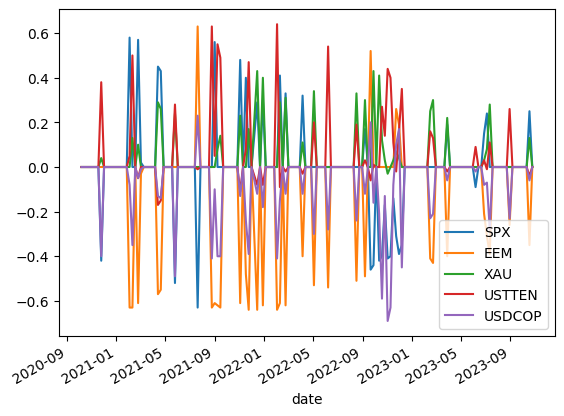

In [52]:
wsqaoa.sub(ws_).round(2).plot()